# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this tutorial we show how to (approximately) solve binary combinatorial optimization problems, using the __Quantum Approximate Optimization Algorithm (QAOA)__, as introduced in Ref.[1]. 
The QAOA algorithm belongs to the class of __hybrid quantum algorithms__ (leveraging both classical as well as quantum compute), that are widely believed to be the working horse for the current __NISQ (noisy intermediate-scale quantum) era__.
In this NISQ era QAOA is also an emerging approach for benchmarking quantum devices and is a prime candidate for demonstrating a practical quantum speed-up on near-term NISQ device [1,4]. 
To validate our approach we benchmark our results with exact results as obtained from classical QUBO solvers. 

We provide a step-by-step walkthrough explaining the QAOA quantum algorithm and show how to build the corresponding parametrized quantum circuit ansatz using the ```Braket``` SDK, with simple modular building blocks (that can be re-used for other purposes). 
We use open-source off-the-shelf ```scipy``` optimizers for classical numerical optimization. 
While we demonstrate our proof-of-concept approach using classical simulators for circuit execution, our code could in principle be run on actual quantum hardware by simply changing the definition of the ```device``` object (provided that the gate set used in the ansatz is supported by the device, as is the case here for IonQ; for Rigetti we need to apply one more extra trick as shown below). 

## BACKGROUND: THE QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM

In this tutorial we will try to solve for the optimal _classical_ bitstring $z$ using the Quantum Approximate Optimization Algorithm (QAOA). 
To this end, we first promote the classical spin variables $z_{i}=-1,1$ to quantum-mechanical variables $\sigma_{i}^{z}$ (with the Pauli matrix $\sigma_{i}^{z}$ representing the observable corresponding to spin along the $z$ coordinate axis in three-dimensional Euclidean space $\mathbb{R}^{3}$). 
This leads to the following quantum mechanical cost Hamiltonian encoding the optimization problem

$$\hat{H}_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z},$$

which can be written as a matrix of size $(2^{N}, 2^{N})$ with diagonal elements only corresponding to all possible classical values for the cost function $H_{C}$. 
The ground state of $\hat{H}_{C}$ corresponds to the optimal solution of the classical combinatorial problem.

__QAOA ansatz__: Finding this ground state is generically hard. 
To approximate this groundstate, QAOA prepares a parametrized ansatz state (corresponding to a parameterized  gate  sequence),  whose  parameters  are iteratively updated by a classical optimizer in a closed loop. 
Specifically, QAOA involves a specific ansatz wavefunction parametrized by a parameter family $(\vec{\beta}, \vec{\gamma})$, embedded into a larger classical optimization loop to find the optimal values for these parameters. 
As shown in Ref.[1], good approximate solutions to the problem class considered here can be found by preparing the variational state 

$$|\gamma, \beta \rangle = U_{x}(\beta_{p})U_{zz}(\gamma_{p}) \cdots U_{x}(\beta_{1})U_{zz}(\gamma_{1}) |s\rangle$$

with single qubit rotations induced by $U_{x}(\beta) = \exp(-i\beta \sum_{i}\sigma_{i}^{x})$, 
and interactions described by $U_{zz}(\gamma) = \exp(-i\gamma H_{C})$,
starting initially from a product of $\sigma^{x}$ eigenstates, i.e.,
$|s\rangle =|-,-,\dots\rangle$, with $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
The family of states $|\gamma, \beta \rangle$ is prepared by alternating single-qubit operations $U_{x}(\beta_{p})$ with targeted spin-spin interactions generated by the cost Hamiltonian $H_{C}$. 
The depth $p$ can be interpreted as a hyperparameter. 
For $p$ layers of QAOA blocks, there are $2p$ classical parameters to optimize over, 
since each layer $k$ is characterized by just two variational parameters, $\gamma_{k}$ and $\beta_{k}$. 
The preparation step outlined above is followed by a measurement in the computational basis, giving a classical string $z$, with which one can evaluate the objective function $H_{C}$ of the underlying combinatorial problem at hand. 
Taking several measurements shots one can build the expectation value $E(\beta, \gamma) = \langle H_{C} \rangle$ that we report as the objective function to the classical minimizer (while other choices could be possible as well). 
Repeating this procedure will provide an optimized string $z$, with the quality of the result improving as the depth of the quantum circuit $\sim 2p$ is increased [1]. 
In fact, in principle (in the absence of noise and other imperfections), QAOA can reach the global optimum of any cost function in the limit $p \rightarrow \infty$ [1], approaching the adiabatic protocol. 
Thus, in theory the computational power of QAOA increases with $p$, but in practice the number of layers that can be executed without errors on NISQ devices is limited due noise and imperfections. 

__Optimization__: Since we are primarily interested in solving the classical optimization problem, within this routine it is sufficient to keep track of the best classical bitstring. 
This means that the wavefunction prepared by the quantum circuit $|\gamma, \beta \rangle$ has to have some overlap with the optimal solution $|z^{*} \rangle$ that we can read out as bitstring $z^{*}$ in the measurement shots. 
To this end, in principle (i.e., without any training), we could just sample from a completely uniform state that is prepared in a superposition of all computational basis states, as prepared by applying Hadamard gates to all qubits: $|\mathrm{uniform}\rangle = 1/\sqrt{2^{N}}\sum_{i}|z_{i}\rangle$. 
In that case (assuming a single optimal solution) the success probability per shot amounts to $p_{\mathrm{success}}=1/2^{N}$. 
We can then amplify our success chances by just taking many measurement shots. 
For large systems, however, this approach is not scalable as we would need to take an exponentially increasing number of measurements. 
That is why we train our circuits, update the parameters, with the goal to increase our success chances to find the optimal bitstring. 
We can quantify our success chances as follows [6]. 
For a given wavefunction $|\gamma, \beta \rangle$ the probability to find the optimal solution in a single shot is given by 

$$ p_{\mathrm{success}}(\gamma, \beta) = |\langle z^{*}|\gamma, \beta \rangle |^{2},$$

where $z^{*}$ denotes the optimal bitstring. 
If we perform $M$ repeated measurements, the overall probability $P$ for observing this solution at least once is given by 

$$ P = 1 - (1-p_{\mathrm{success}}(\gamma, \beta))^{M}, $$ 

since the term $(1-p_{\mathrm{success}}(\gamma, \beta))^{M}$ gives the probability of _not_ obtaining $z^{*}$ in repeated $M$ trials. 
Therefore, to have an overall success chance up to $\epsilon$ close to 100%, i.e., $P \geq 1-\epsilon$, the number of required shots has to be 

$$ M \geq \frac{\log(\epsilon)}{\log(1-p_{\mathrm{success}}(\gamma, \beta))}.$$

Let us illustrate this results as follows: 
If we do not know anything and just resort to a uniform superposition $|\mathrm{uniform}\rangle$, for a small system with $N=10$ qubits we can find the optimal solutions with 80% success probability by taking at least $\sim 1650$ shots. 
For just $N=20$ qubits, however, this number amounts to $\sim 1.7 \times 10^{6}$, making this naive approach unfeasible. 
Conversely, if we can train the quantum circuit to obtain $p_{\mathrm{success}}(\gamma, \beta) \sim 0.1$, we only need $\sim 15$ shots to have $P\geq 80\%$. 
Below we will track and illustrate the best classical optimum as our algorithm proceeds towards a local or (ideally) global optimum.  

__Objective function__: Finally, some more details on the definition of the cost function are in order. 
Following the standard approach [1, 4], QAOA tries to minimize the expectation value $\langle \hat{H}_{C} \rangle$, but does _not_ explicitly maximize the success probability [6]. 
However, a low expectation value for $\langle \hat{H}_{C} \rangle$ does not necessarily translate to a high success probability $p_{\mathrm{success}}(\gamma, \beta)$, as can be understood from the following example:
Consider (for example) a variational state that is a linear combination of low energy excited eigenstates of the cost Hamiltonian $\hat{H}_{C}$ other than the ground state $|z^{*}\rangle$. 
By definition, this state will have a relatively low expectation value $\langle \hat{H}_{C} \rangle$ while the success probability is zero (as this low energy state does not have any overlap with the ground state). 
Similarly, a variational state that is a linear combination of the ground state with very high energy eigenstates could have a high success probability $p_{\mathrm{success}}(\gamma, \beta)$, while (at the same time) reporting a high cost value to the classical optimizer.
To address this issue, alternative methods for the optimization of the variational parameters have recently been proposed. 
While for simplicity we follow the majority of the literature and take $\langle \hat{H}_{C} \rangle$ as cost value that we report to the classical optimizer, here we do mention a potential alternative for future research: 
One approach is to use the Gibbs objective function, defined as $\mathrm{cost}=-\mathrm{log} \langle \exp(-\eta \hat{H}_{C})\rangle$, with the hyperparameter $\eta>0$ [7]. 
As compared to the simple expectation value $\langle \hat{H}_{C} \rangle$, this definition of the cost value shows stronger rewards for low energy states, thereby increasing the success probability. 

## IMPLEMENTATION OF QAOA WITH BRAKET 

We consider a graph coloring problem.
Given a graph $G=(V,E)$, made of a set vertices (also called nodes) $V$ and edges $E$, our goal is to color each node red or blue, then score a point for each node that is next to a node of different color. 
We strive to find the optimal coloring that scores the largest number of points.
To this end, we will address the dual problem of finding the minimum energy of the corresponding Ising Hamiltonian. 
To get started, we first use the open-source ```networkx``` library to visualize the problem graph. 
Feel free to play with the parameters $n$ (for the number of nodes) and $m$ (for the number of edges) below to consider other graphs of your choice. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

In [2]:
from braket.aws import AwsSession, AwsDevice
from braket.devices import LocalSimulator
from braket.experimental.algorithms.qaoa.qaoa import qaoa, run_qaoa, get_qaoa_results 

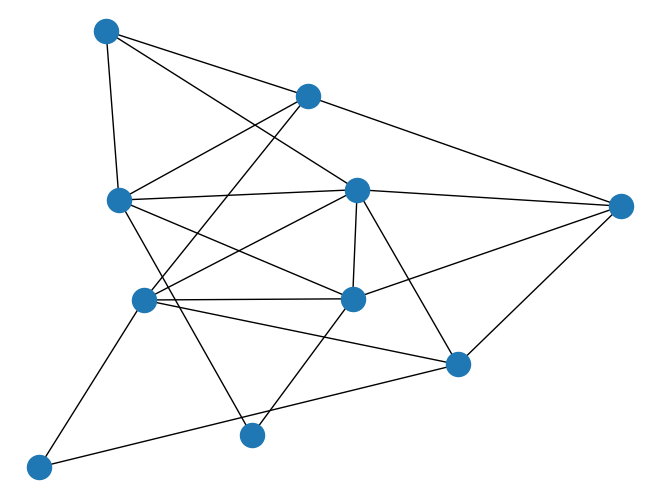

In [3]:
# setup Erdos Renyi graph
n = 10  # number of nodes/vertices
m = 20  # number of edges
seed = 42
np.random.seed(seed)
random.seed(a=seed)

# define graph object
G = nx.gnm_random_graph(n, m, seed=seed)
# positions for all nodes
pos = nx.spring_layout(G)

# choose random weights
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.uniform(0, 1)

# draw graph
nx.draw(G, pos)
plt.show()

In [4]:
# set Ising matrix 
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)

# get off-diagonal upper triangular matrix
J = np.triu(Jfull, k=1).astype(np.float64)

## QAOA SIMULATION ON LOCAL SCHROEDINGER SIMULATOR

We are now all set to run some QAOA simulation experiments. 
First of all, you can play and experiment yourself with the number of qubits $N$. 
Secondly, you may also experiment with the classical optimizer. 
Since we are using an off-the-shelf, black-box ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```OPT_METHOD``` parameter below. 
Some popular options readily available within this library include *Nelder-Mead*, *BFGS* and *COBYLA*. 
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized QAOA ansatz wavefunction. 
To address this issue, we may run several optimization loops, starting from different random parameter seeds. 
While this brute-force approach does not provide any guarantee to find the global optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the simulator or QPU, respectively.
Finally, the optimization loop may require the execution of many individual quantum tasks (i.e., single circuit executions for fixed parameters). 
For example, when choosing the classical [Powell](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) optimizer for the graph considered here, we find $\sim 270$ cycles in the for loop. 
For the local simulator device chosen here by default this is not an issue, but if you run this algorithm on any QPU you may want to adjust the ```maxfev``` parameter to control the maximum allowed number function evaluations (compare comment in the next code block below).

In [5]:
device = LocalSimulator()

In [6]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 3  # circuit depth for QAOA
SHOTS = 10  # number measurements to make on circuit
OPT_METHOD = 'Powell'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...

# set up the problem
n_qubits = J.shape[0]

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# set tracker to keep track of results
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_bitstrings': [],                 # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}

# set options for classical optimization
options = {'disp': True, 'maxiter': 500}

In [7]:
##################################################################################
# run QAOA optimization on graph 
##################################################################################

print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n_qubits)

# kick off training
result, tracker = run_qaoa(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits, n_shots=SHOTS, 
    opt_method=OPT_METHOD, tracker=tracker)

Circuit depth hyperparameter: 3
Problem size: 10
Training in progress...
Optimization terminated successfully.
         Current function value: -0.937169
         Iterations: 2
         Function evaluations: 243


In [8]:
get_qaoa_results(result, tracker)

Optimal energy: -6.486032631497276
Optimal classical bitstring: [-1  1 -1 -1  1 -1  1  1 -1 -1]
Final average energy (cost): -0.937169150437591
Final angles: [4.88261413 2.60870766 2.26309012 1.6607821  1.28592103 2.39641137]
